In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

### 1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

###  1) Количество листьев

In [264]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_samples=1000, n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

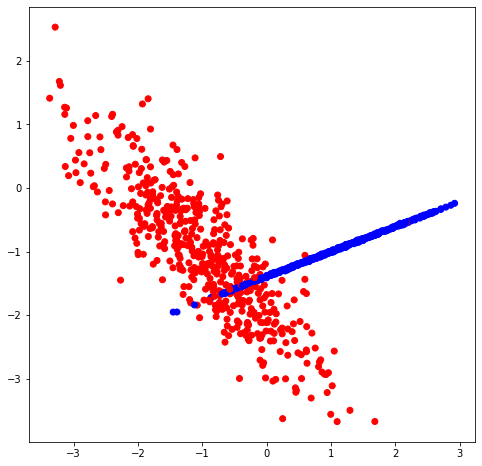

In [265]:
# визуализируем сгенерированные данные
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [266]:
# Реализуем класс узла
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле


In [267]:
# И класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
                
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [268]:
# Расчет критерия Джини
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1     # "impurity" - "нечистота", степень неопределенности
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [269]:
# Расчет качества
def quality(left_labels, right_labels, current_gini):

    # доля выборки, ушедшей в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [270]:
# Разбиение датасета в узле
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [271]:
# Нахождение наилучшего разбиения
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [272]:
# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels, max_leafs, leafs_count):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0 or max_leafs==1 or max_leafs==len(leafs_count)+1:
        leaf = Leaf(data, labels)
        leafs_count.append(leaf)
        return leaf

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, max_leafs-1, leafs_count)
    false_branch = build_tree(false_data, false_labels, max_leafs, leafs_count)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [273]:
# Проход объекта по дереву для его классификации
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [274]:
# Предсказание деревом для всего датасета
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [275]:
# Разобьем выборку на обучающую и тестовую
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [276]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, max_leafs=12, leafs_count=[])

In [277]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0
Порог -0.001967524769128759
--> True:
  Индекс 1
  Порог -1.3993975578815423
  --> True:
    Индекс 1
    Порог -1.6646404646216442
    --> True:
      Индекс 0
      Порог -0.8728986138474495
      --> True:
        Прогноз: 0
      --> False:
        Прогноз: 0
    --> False:
      Индекс 0
      Порог -0.6882680999463433
      --> True:
        Прогноз: 0
      --> False:
        Индекс 0
        Порог -0.40118216125291906
        --> True:
          Индекс 1
          Порог -1.5684737117409848
          --> True:
            Индекс 0
            Порог -0.5543283463967666
            --> True:
              Прогноз: 1
            --> False:
              Прогноз: 1
          --> False:
            Прогноз: 0
        --> False:
          Индекс 1
          Порог -1.5264301097909836
          --> True:
            Прогноз: 1
          --> False:
            Индекс 1
            Порог -1.4255078037225668
            --> True:
              Прогноз: 1
            --> False:
   

In [278]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [279]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [280]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [281]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

98.14285714285714

In [282]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

95.0

Text(0.5, 1.0, 'Test accuracy=95.00')

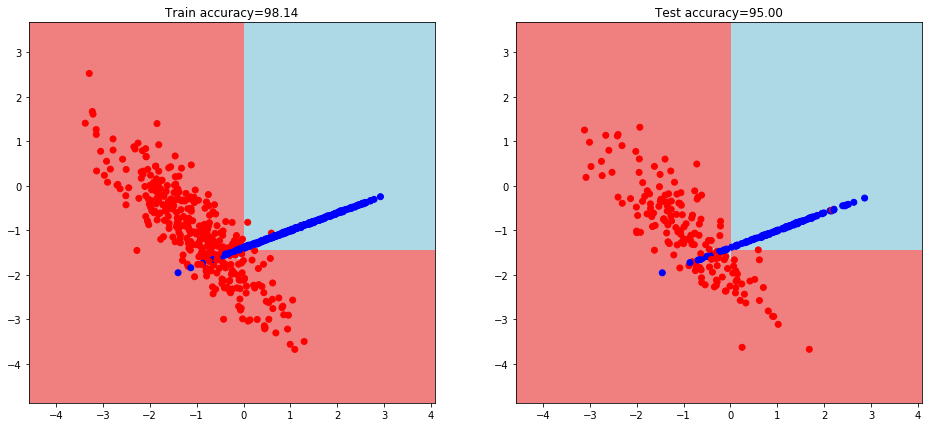

In [283]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

### 2) Количество узлов

### 2*. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [54]:
# сгенерируем данные
regression_data, regression_targets = datasets.make_regression(n_features = 2, n_informative = 2, random_state=33)

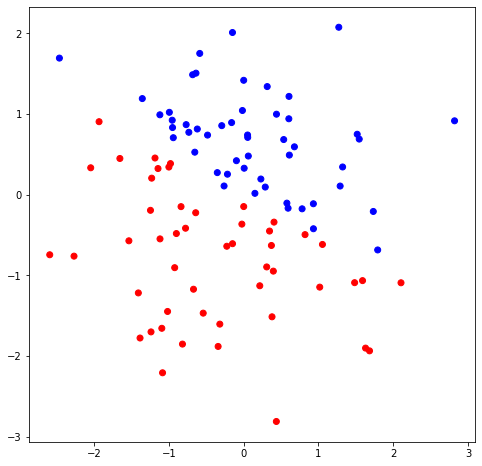

In [55]:
# визуализируем сгенерированные данные
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], regression_data)), list(map(lambda x: x[1], regression_data)), 
              c=regression_targets, cmap=colors)

In [56]:
# Реализуем класс узла
class regr_Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [57]:
# И класс терминального узла (листа)
class regr_Leaf:
    
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets  # y_true
        self.prediction = self.targets.mean()  # y_pred

In [58]:
# Расчет качества
def regr_quality(left_targets, right_targets, current_var):

    # доля выборки, ушедшей в левое поддерево
    p = float(left_targets.shape[0]) / (left_targets.shape[0] + right_targets.shape[0])
    
    return current_var - p * left_targets.var() - (1 - p) * right_targets.var()

In [59]:
# Разбиение датасета в узле
def regr_split(data, targets, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_targets = targets[left]
    false_targets = targets[right]
        
    return true_data, false_data, true_targets, false_targets

In [60]:
# Нахождение наилучшего разбиения
def regr_find_best_split(data, targets):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_var = targets.var()

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, left_targets, right_targets = regr_split(data, targets, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(left_targets) < min_leaf or len(right_targets) < min_leaf:
                continue
            
            current_quality = regr_quality(left_targets, right_targets, current_var)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [61]:
# Построение дерева с помощью рекурсивной функции
def regr_build_tree(data, targets):

    quality, t, index = regr_find_best_split(data, targets)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return regr_Leaf(data, targets)

    left_data, right_data, left_targets, right_targets = regr_split(data, targets, index, t)

    # Рекурсивно строим два поддерева
    left_branch = regr_build_tree(left_data, left_targets)
    right_branch = regr_build_tree(right_data, right_targets)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return regr_Node(index, t, left_branch, right_branch)

In [62]:
# Проход объекта по дереву для его классификации
def regr_classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, regr_Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return regr_classify_object(obj, node.true_branch)
    else:
        return regr_classify_object(obj, node.false_branch)

In [63]:
# Предсказание деревом для всего датасета
def regr_predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = regr_classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [64]:
# Разобьем выборку на обучающую и тестовую
from sklearn import model_selection

train_data, test_data, train_targets, test_targets = model_selection.train_test_split(regression_data, 
                                                                                     regression_targets, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [65]:
# Построим дерево по обучающей выборке
my_tree_regr = regr_build_tree(train_data, train_targets)

In [66]:
# Напечатаем ход нашего дерева
def regr_print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, regr_Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    regr_print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    regr_print_tree(node.false_branch, spacing + "  ")
    
regr_print_tree(my_tree_regr)

Индекс 1
Порог -0.1926922633323755
--> True:
  Индекс 0
  Порог -0.3188535051081303
  --> True:
    Индекс 1
    Порог -1.2163238137027035
    --> True:
      Прогноз: -200.85897756708638
    --> False:
      Прогноз: -131.65684586600537
  --> False:
    Индекс 1
    Порог -0.9462252461334815
    --> True:
      Прогноз: -91.71270346369988
    --> False:
      Прогноз: -21.711511606975012
--> False:
  Индекс 1
  Порог 0.45550421999136287
  --> True:
    Индекс 0
    Порог -0.8376449460249225
    --> True:
      Прогноз: -31.772155356872883
    --> False:
      Прогноз: 29.48528375594023
  --> False:
    Индекс 0
    Порог -0.6535601212741409
    --> True:
      Прогноз: 34.93553031776061
    --> False:
      Индекс 1
      Порог 0.8945409942817496
      --> True:
        Прогноз: 90.99055815016129
      --> False:
        Прогноз: 149.25218903034954


In [67]:
# Получим ответы для обучающей выборки 
regr_train_answers = regr_predict(train_data, my_tree_regr)

In [68]:
# И получим ответы для тестовой выборки
regr_answers = regr_predict(test_data, my_tree_regr)

In [69]:
# Введем функцию подсчета точности как доли правильных ответов
def regr_accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [70]:
# Точность на обучающей выборке
regr_train_accuracy = regr_accuracy_metric(train_targets, regr_train_answers)
regr_train_accuracy

0.0

In [71]:
# Точность на тестовой выборке
regr_test_accuracy = regr_accuracy_metric(test_targets, regr_answers)
test_accuracy

0.0

Text(0.5, 1.0, 'Test accuracy=0.00')

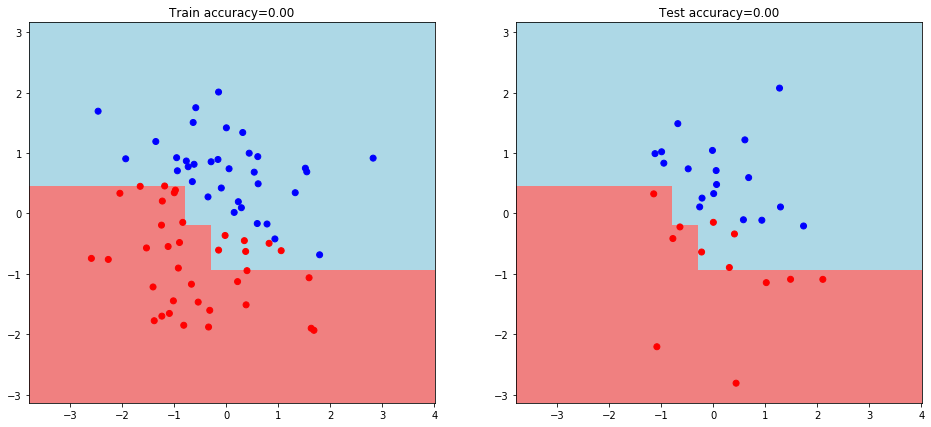

In [72]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(regr_predict(np.c_[xx.ravel(), yy.ravel()], my_tree_regr)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_targets, cmap = colors)
plt.title(f'Train accuracy={regr_train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_targets, cmap = colors)
plt.title(f'Test accuracy={regr_test_accuracy:.2f}')